In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Preparation:
```
Remove the student_id column.
Fill missing values with zeros.
Do train/validation/test split with 60%/20%/20% distribution.
Use the train_test_split function and set the random_state parameter to 1.
Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
```

In [4]:
df = pd.read_csv("https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv")

In [5]:
df.head().T

,0,1,2,3,4
JAMB_Score,192,207,182,210,199
Study_Hours_Per_Week,22,14,29,29,12
Attendance_Rate,78,88,87,99,98
Teacher_Quality,4,4,2,2,3
Distance_To_School,12.4,2.7,9.6,2.6,8.8
School_Type,Public,Public,Public,Public,Public
School_Location,Urban,Rural,Rural,Urban,Urban
Extra_Tutorials,Yes,No,Yes,No,No
Access_To_Learning_Materials,Yes,Yes,Yes,Yes,Yes
Parent_Involvement,High,High,High,Medium,Medium


In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [8]:
del df['student_id']

In [11]:
df = df.fillna(0)

In [20]:
y = df.jamb_score.values
del df['jamb_score']

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

# split dataset
df_full_train, df_test, y_full, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full, test_size=len(df_test), random_state=1)

# turn into matrices
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

### Question 1

Let's train a decision tree regressor to predict the jamb_score variable.
```
Train a model with max_depth=1.
```

In [31]:
from sklearn.tree import DecisionTreeRegressor, export_text

dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)
print(export_text(dtr, feature_names=dv.get_feature_names_out()))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



**Answer:** *study_hours_per_week*

### Question 2

Train a random forest regressor with these parameters:
```
n_estimators=10
random_state=1
n_jobs=-1 (optional - to make training faster
```

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

rf = RandomForestRegressor(n_estimators=10,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)
y_preds = rf.predict(X_val)
root_mean_squared_error(y_val, y_preds)

42.13724207871227

**Answer:** 42.13

### Question 3
Now let's experiment with the n_estimators parameter

```
Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.
```

In [70]:
rf_scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n,
                            random_state=1,
                            n_jobs=-1)
    rf.fit(X_train, y_train)
    y_preds = rf.predict(X_val)
    rf_scores.append((n, root_mean_squared_error(y_val, y_preds).round(3)))

(40.4, 42.25)

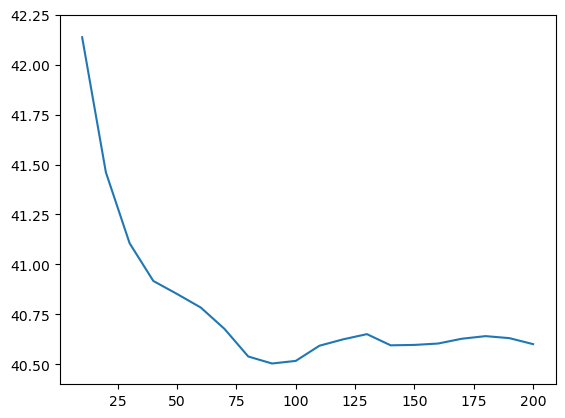

In [71]:
rf_scores_df = pd.DataFrame(rf_scores, columns=['n_estimators', 'rmse'])
plt.plot(rf_scores_df.n_estimators, rf_scores_df.rmse)
plt.ylim(40.4, 42.25)

**Answer:** 80~

### Question 4

Let's select the best max_depth:
```
Try different values of max_depth: [10, 15, 20, 25]
For each of these values,
try different values of n_estimators from 10 till 200 (with step 10)
calculate the mean RMSE
Fix the random seed: random_state=1
```

In [74]:
rf_scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                max_depth=d,
                                random_state=1,
                                n_jobs=-1)
        rf.fit(X_train, y_train)
        y_preds = rf.predict(X_val)
        rf_scores.append((d, n, root_mean_squared_error(y_val, y_preds).round(3)))

rf_scores_df = pd.DataFrame(rf_scores, columns=['max_depth', 'n_estimators', 'rmse'])

<Axes: xlabel='n_estimators', ylabel='max_depth'>

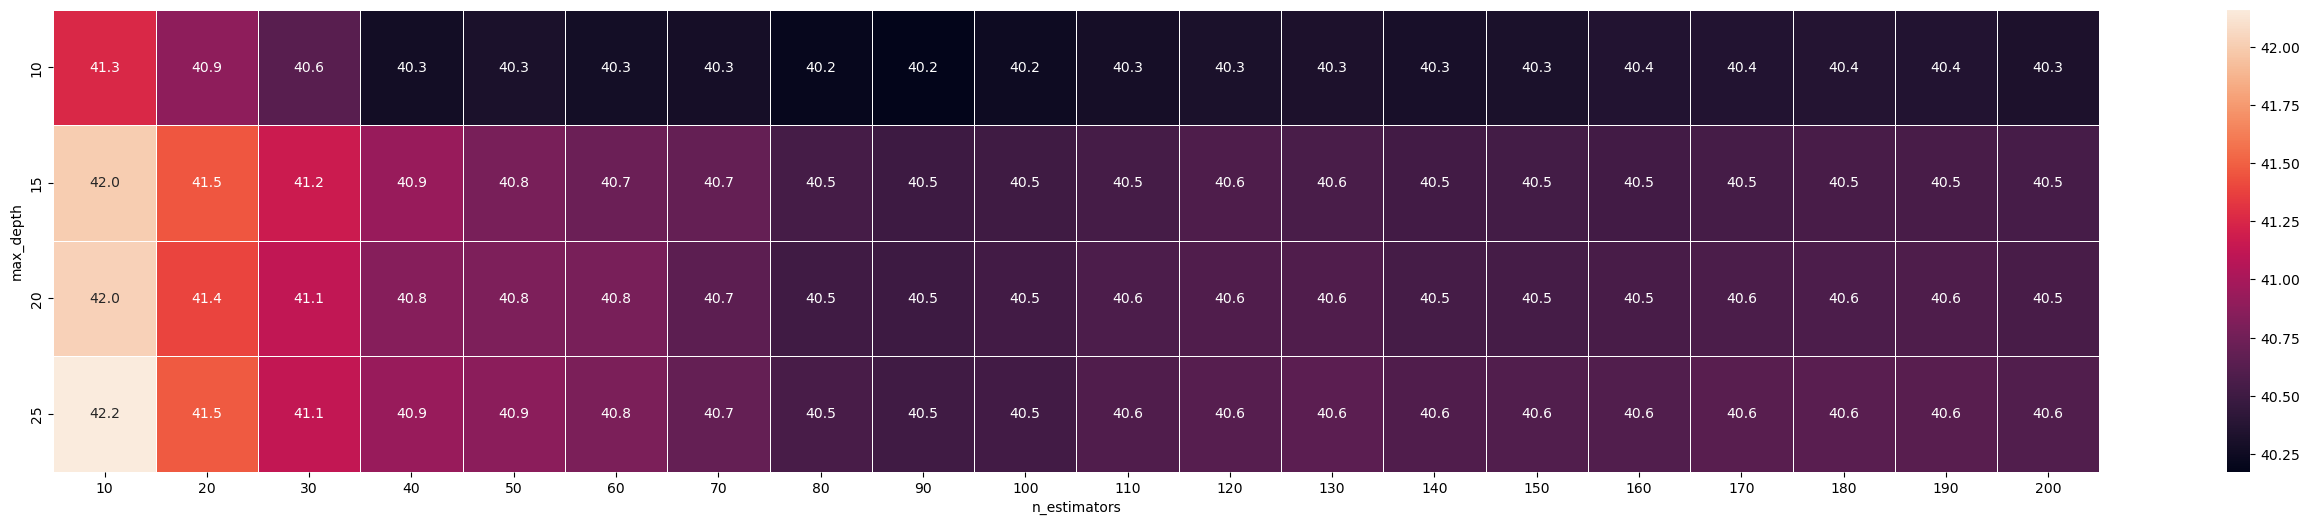

In [73]:
fig, ax = plt.subplots(figsize=(33, 6)) 
sns.heatmap(rf_scores_df.pivot(index='max_depth', columns='n_estimators', values='rmse'), fmt='.3', linewidths=0.5, annot=True, ax=ax)

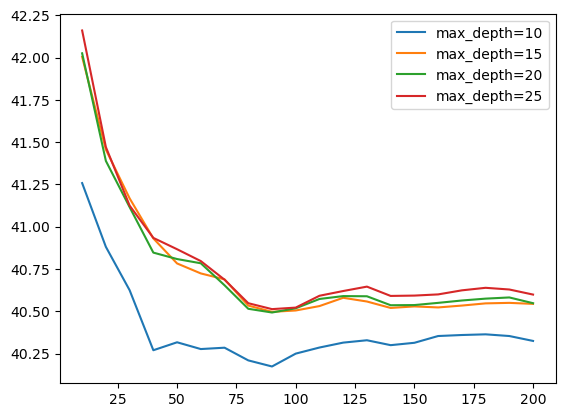

In [77]:
for d in [10, 15, 20, 25]:
    df_subset = rf_scores_df[rf_scores_df.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%s' % d)
plt.legend()

**Answer:** 10

### Question 5

For this homework question, we'll find the most important feature:
```
Train the model with these parameters:
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1 (optional)
```

In [83]:
rf = RandomForestRegressor(n_estimators=10,
                            max_depth=20,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)
feature_imp = pd.DataFrame(list(zip(rf.feature_importances_, dv.get_feature_names_out())), columns=['importance', 'feature'])
feature_imp.sort_values(by='importance', ascending=False).head()

,importance,feature
27,0.248354,study_hours_per_week
4,0.149729,attendance_rate
5,0.136486,distance_to_school
28,0.082682,teacher_quality
2,0.069311,age


**Answer:** *study_hours_per_week*

### Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

```
Install XGBoost
Create DMatrix for train and validation
Create a watchlist
Train a model with these parameters for 100 rounds:
```

In [ ]:
import xgboost as xgb

In [130]:
def parse_xgboost_output(output):
    s = output.stdout
    parsed_results = []
    # for each line excluding the last element which is ['']
    for line in s.split('\n')[:-1]: 
        n_iter, val_rmse = line.split('\t')
        n_iterations = n_iter.strip('[]')
        val, vscore = val_rmse.split(':')
        parsed_results.append((int(n_iterations), float(vscore)))
    df_xgb_results = pd.DataFrame(parsed_results, columns=['n_iteration', 'val_rmse'])
    return df_xgb_results

In [160]:
%%capture output

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=[(dval, 'val')],
          num_boost_round=100)

In [161]:
df_score_1 = parse_xgboost_output(output)

In [162]:
%%capture output

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=[(dval, 'val')],
          num_boost_round=100)

In [163]:
df_score_2 = parse_xgboost_output(output)

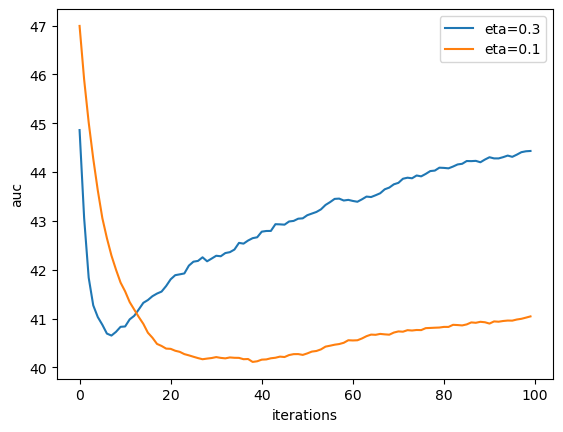

In [164]:
plt.plot(df_score_2.n_iteration, df_score_2.val_rmse, label='eta=%s' % 0.3)
plt.plot(df_score_1.n_iteration, df_score_1.val_rmse, label='eta=%s' % 0.1)
plt.xlabel('iterations')
plt.ylabel('auc');
plt.legend()

**Answer:** eta=0.1